In [1]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib.pyplot as plt

rng = np.random.default_rng()

T = 250 # how long to simulate the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = state_dim # for now
NUM_TRAJ_TRAIN = 100 # number of trajectories to simulate for training data
NUM_TRAJ_TEST = 20
num_trajs = NUM_TRAJ_TRAIN + NUM_TRAJ_TEST

import time

In [2]:
theta = 1/360*2*np.pi # one degree

A = np.array([[np.cos(theta), -np.sin(theta)], # state transition matrix
              [np.sin(theta),  np.cos(theta)]]) # moving around a circle at 1 deg per timestep
B = np.array([[0.5], [0.7]]) # input transformation
# B = np.zeros(shape=(state_dim, input_dim)) # ignore inputs for now
C = np.eye(obs_dim, state_dim) # Using identity map for now
Q = 0.001*np.eye(state_dim) # Covariance matrix of process noise
R = 0.01*np.eye(obs_dim) # Covariance matrix of sensor noise
x0 = np.array([1.0, 0.0], dtype=np.float64) # starting state
u_seq = 0.05 * (rng.random(size=(num_trajs, T, input_dim))*2 - 1)
traj = np.zeros(shape=(num_trajs, T, state_dim))
meas = np.zeros(shape=(num_trajs, T, obs_dim))

for traj_index in range(num_trajs):
    x = x0
    for i in range(T):
        u_t = u_seq[traj_index, i]
        w_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=Q) # process noise
        x = A @ x + w_t + B @ u_t # inputs
        v_t = rng.multivariate_normal(mean=np.zeros(obs_dim), cov=R) # sensor noise
        y = C @ x + v_t
        traj[traj_index, i] = x
        meas[traj_index, i] = y

<Figure size 432x288 with 0 Axes>

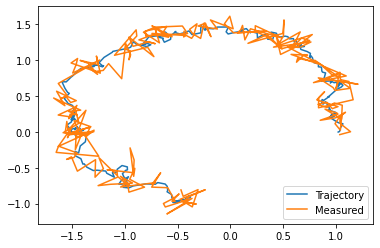

In [3]:
index_to_visualize = 1

# plot trajectory and noisy measurements
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[index_to_visualize, :,0], traj[index_to_visualize, :,1], label='Trajectory')
linemeas, = ax.plot(meas[index_to_visualize, :,0], meas[index_to_visualize, :,1], label='Measured')

plt.legend()
plt.show()

# Now, let's see if a transformer can learn the dynamics and filter the position

In [4]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 36 # use 36-dimensional embedding for now
batch_size = 10

### Train-Test Split

In [5]:
# Training Data
indices_train = np.arange(NUM_TRAJ_TRAIN)
np.random.shuffle(indices_train)

# The input to the model will be a concatenation of the current measured state and the "u" input at this timestep
target_sequences_train = torch.from_numpy(meas)[indices_train,:,:]
input_sequences_train = torch.from_numpy(u_seq)[indices_train,:,:]
transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)

# Test Data
indices_test = np.arange(NUM_TRAJ_TRAIN, NUM_TRAJ_TRAIN+NUM_TRAJ_TEST)
np.random.shuffle(indices_test)

traj_test = traj[indices_test,:,:]
meas_test = meas[indices_test,:,:]
target_sequences_test = torch.from_numpy(meas)[indices_test,:,:]
input_sequences_test = torch.from_numpy(u_seq)[indices_test,:,:]
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)


## GPT-style: Transformer Decoder only for Autoregressive generation

Compare to:
* Just the last timestep (ZOH) 
* Run A, B system on last timesteps (no noise) 

In [6]:
num_epochs = 20

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=state_dim,
                 n_layers=3, n_heads=6, d_filter=256, dropout=None)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_epochs):
    for batchNum in range(NUM_TRAJ_TRAIN // batch_size):
        
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]  
        
#         print(transformer_input_batch.shape)
#         print(target_sequence_batch.shape)
        decoder_output = gpt_model(transformer_input_batch, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

        loss = loss_func(decoder_output, target_sequence_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 450.96956110633505
Epoch 1 : Loss 248.04968416371867
Epoch 2 : Loss 159.5941539846528
Epoch 3 : Loss 136.32628825231004
Epoch 4 : Loss 119.78445196174741
Epoch 5 : Loss 109.23545145759135
Epoch 6 : Loss 105.27922656437062
Epoch 7 : Loss 103.55740580051688
Epoch 8 : Loss 101.78339779209718
Epoch 9 : Loss 100.70641366541032
Epoch 10 : Loss 99.62722344523627
Epoch 11 : Loss 98.82212213396467
Epoch 12 : Loss 97.96875443804234
Epoch 13 : Loss 97.28080690801868
Epoch 14 : Loss 96.78930026207195
Epoch 15 : Loss 96.74707232968429
Epoch 16 : Loss 97.07945820430231
Epoch 17 : Loss 97.2409780248986
Epoch 18 : Loss 96.93752726966953
Epoch 19 : Loss 96.35709284934356


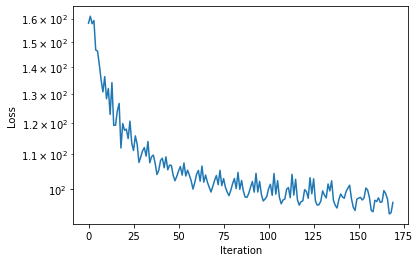

In [7]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

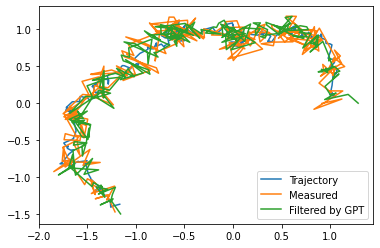

Error between traj and meas 0.5013165600402327
Error between filtered and traj 0.4708136101314885
Error between filtered and meas 0.3053327685348585


In [9]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=False)

# Index that we want to visualize from the test indices
ind_to_vis = 4

filtered = gpt_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linegpt, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by GPT')
plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and traj', np.linalg.norm(filtered - traj_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / NUM_TRAJ_TEST)

## BERT-style: Transformer Encoder only, fill in the blanks for the trajectory 

Compare to: 
* Average between different timesteps for the missing ones (PWL linear interpolation)
* Just the last step (ZOH interpolation)

In [26]:
num_epochs = 40
p = 0.15 # probability of zeroing out a token

bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
                embed_size=embed_dim, output_size=state_dim, 
                n_layers=3, n_heads=6, d_filter=256, 
                dropout=None)
optimizer = torch.optim.Adam(bert_model.parameters())

#Randomly zero-out 20% of the tokens in target_sequences_train
mask = torch.bernoulli( (1-p) * torch.ones(size=(NUM_TRAJ_TRAIN, T) ) )
mask = mask.repeat(obs_dim+input_dim, 1, 1).permute(1, 2, 0)
# print("mask is", mask)

transformer_input_train_masked = transformer_input_train * mask

loss_func = torch.nn.MSELoss(reduction='sum')
losses = []

for i in range(num_epochs):
    for batchNum in range(NUM_TRAJ_TRAIN // batch_size):
        
        transformer_input_batch = transformer_input_train_masked[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        # transformer_input_batch has shape [batch_size, seq_len, (obs_dim+input_dim)] 
        
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
       
         # What percent of them are zeroed out?
#         zeroed = 0
#         for batch in transformer_input_batch: 
#             for seq_elt in batch: 
#                 if all(seq_elt == 0.0): zeroed += 1
#         print("percent zeroed", zeroed / (batch_size * T) )
        
        encoder_output = bert_model(transformer_input_batch, encoder_mask=None)

        loss = loss_func(encoder_output, target_sequence_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 732.6172218731201
Epoch 1 : Loss 407.5335333580919
Epoch 2 : Loss 364.9317811624445
Epoch 3 : Loss 305.6947085902014
Epoch 4 : Loss 279.0749743763553
Epoch 5 : Loss 267.6433593672072
Epoch 6 : Loss 257.33093358051656
Epoch 7 : Loss 235.83373178063778
Epoch 8 : Loss 210.70800204456881
Epoch 9 : Loss 197.08339723679427
Epoch 10 : Loss 185.4737972351051
Epoch 11 : Loss 174.4353530684368
Epoch 12 : Loss 161.9656292521676
Epoch 13 : Loss 149.91234006738958
Epoch 14 : Loss 138.4244238215979
Epoch 15 : Loss 126.08207780938149
Epoch 16 : Loss 113.33233884030474
Epoch 17 : Loss 103.59436464425596
Epoch 18 : Loss 94.77494971915482
Epoch 19 : Loss 87.27941009940255
Epoch 20 : Loss 80.45345905051938
Epoch 21 : Loss 74.54606292869016
Epoch 22 : Loss 69.46606833564867
Epoch 23 : Loss 64.93564523475402
Epoch 24 : Loss 60.99848273073898
Epoch 25 : Loss 57.445236107692295
Epoch 26 : Loss 54.23380293754658
Epoch 27 : Loss 51.34298941157907
Epoch 28 : Loss 48.684764774425794
Epoch 29 : Los

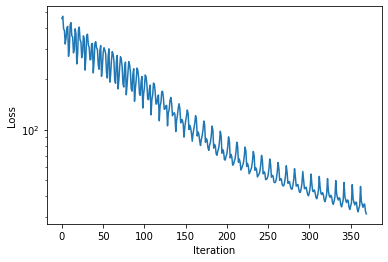

In [27]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

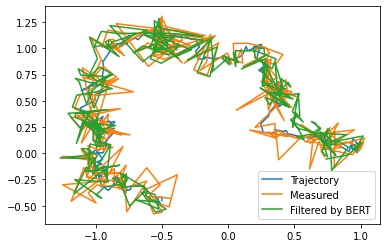

Error between traj and meas 0.5013165600402327
Error between filtered and traj 0.5366686361039158
Error between filtered and meas 0.3791453127549852


In [28]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
ind_to_vis = 12

filtered = bert_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linegpt, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by BERT')
plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and traj', np.linalg.norm(filtered - traj_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / NUM_TRAJ_TEST)